# Data analysis for Vitrimer Tensile Data
To run this notebook you must have the following directories with the relevant CSV files,
- DestructiveTests/Tensile/FIBERGLASS TENSILE.is_qtest_Exports
- DestructiveTests/Tensile/FLAX TENSILE.is_qtest_Exports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
import typing as t
import pydantic
from pydantic import BaseModel, PrivateAttr

import pywt
from scipy import signal


In [3]:
class TensileData(BaseModel):
    file_path: str
    dimensions: t.Optional[t.Tuple[float, float]] = None  # (width, thickness) in mm
    gauge_length: t.Optional[float] = None  # Gauge length in mm
    _csa: t.Optional[float] = PrivateAttr(None)  # Calculated cross-sectional area in mm^2

    internal_name: str

    raw_data: t.Optional[pd.DataFrame] = None
    stressStrain_data: t.Optional[pd.DataFrame] = None
    stress_spike_index: t.Optional[int] = None

    _scalogram: t.Optional[t.Dict[str, t.Optional[np.ndarray]]] = PrivateAttr(None)

    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)

    def model_post_init(self, __context):
        self.load_data()

    def load_data(self):
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File {self.file_path} not found.")

        self.raw_data = pd.read_csv(self.file_path, header=0, skiprows=[1])
        if 'Displacement' in self.raw_data.columns:
            self.raw_data['Displacement'] -= self.raw_data['Displacement'].iloc[0]
        if 'Force' in self.raw_data.columns:
            self.raw_data['Force'] -= self.raw_data['Force'].iloc[0]

        if self.dimensions:
            width, thickness = self.dimensions
            self._csa = width * thickness

        if self.raw_data is not None and self._csa and self.gauge_length:
            df = self.raw_data.copy()
            df['Stress (MPa)'] = df['Force'] * 1000 / self._csa
            df['Strain'] = df['Displacement'] / self.gauge_length
            self.stressStrain_data = df
            self.stress_spike_index = self.detect_stress_spike()
            # If the stress spike index is detected, subtract the associated strain from all strains
            if self.stress_spike_index is not None:
                spike_strain = self.stressStrain_data['Strain'].iloc[self.stress_spike_index]
                self.stressStrain_data['Strain'] -= spike_strain
        else:
            if self.raw_data is None:
                raise ValueError("Raw data not loaded. Please check the file path.")
            if self._csa is None:
                raise ValueError("Cross-sectional area not calculated. Provide dimensions.")
            if self.gauge_length is None:
                raise ValueError("Gauge length not provided.")

    def plot_data(self):
        if self.raw_data is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(self.raw_data['Displacement'], self.raw_data['Force'], linestyle='-', color='b')
            plt.title('Force vs Displacement')
            plt.xlabel('Displacement (mm)')
            plt.ylabel('Force (kN)')
            plt.grid()
            plt.show()
        else:
            raise ValueError("Raw data not loaded.")

    def plot_stress_strain(self, ax_supplied: t.Optional[plt.Axes] = None, label: t.Optional[str] = None, use_percent: bool = True):
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")

        df = self.stressStrain_data
        strain = df['Strain'] * 100 if use_percent else df['Strain']
        stress = df['Stress (MPa)']

        if ax_supplied is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        else:
            ax = ax_supplied

        ax.plot(strain, stress, label=label or f"Sample {self.internal_name}")
        
        if ax_supplied is None:
            ax.set_title('Stress vs Strain')
            ax.set_xlabel('Strain (%)' if use_percent else 'Strain (unitless)')
            ax.set_ylabel('Stress (MPa)')
            ax.grid(True)
            plt.show()

    def detect_stress_spike(self, window: int = 50, threshold: float = 2.5) -> t.Optional[int]:
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")

        stress_series = self.stressStrain_data['Stress (MPa)']
        differences = stress_series.diff().dropna()

        rolling_mean = differences.rolling(window=window).mean()
        rolling_std = differences.rolling(window=window).std()
        z_scores = (differences - rolling_mean) / rolling_std

        spike_indices = z_scores[z_scores > threshold].index
        # Check if the stress is close to zero before returning the first spike index
        if not spike_indices.empty:
            if stress_series.iloc[spike_indices[0]] < 1:  # If stress is close to zero
                return spike_indices[0]
        return None  # No spike detected
    
    def compute_scalogram(self):
        # pick sample
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")
        df     = self.stressStrain_data
        stress = df['Stress (MPa)'].values

        # 1) detrend to remove slow ramp
        stress_dt = signal.detrend(stress)

        # 2) CWT
        dt     = 0.1          # 100 ms sampling
        scales = np.arange(1,256)
        coeffs, freqs = pywt.cwt(stress_dt, scales, 'morl', sampling_period=dt)
        power = np.abs(coeffs)
        # convert to decibels (add small ε to avoid log of zero)
        power_db = 10 * np.log10(power + 1e-6)

        scalogram_results: t.Dict[str, t.Optional[np.ndarray]] = {
            'time': df['Time'].values,
            'frequencies': freqs,
            'power': power,
            'power_db': power_db
        }
        self._scalogram = scalogram_results

    def plot_scalogram(self, title: t.Optional[str] = None, xlim: t.Optional[t.Tuple[float, float]] = None, useDB: bool = True):
        if not self._scalogram:
            # If scalogram is not computed, compute it
            self.compute_scalogram()

        if 'power_db' not in self._scalogram or 'frequencies' not in self._scalogram:
            raise ValueError("Scalogram data not available. Please compute the scalogram first.")

        power = self._scalogram['power']
        power_db = self._scalogram['power_db']
        freqs = self._scalogram['frequencies']
        time = self._scalogram['time']

        fig, ax = plt.subplots(figsize=(12,6))
        contour = ax.contourf(time, freqs, power_db if useDB else power, levels=100, cmap='magma')
        ax.set_yscale('log')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_xlabel('Time (s)')
        if xlim:
            ax.set_xlim(left=xlim[0], right=xlim[1])
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title(title or ('Scalogram of Stress Signal for Sample ' + self.internal_name))
        cb = fig.colorbar(contour, ax=ax, label='Power (dB)')
        plt.show()



## Flax Measurements

CSV files in the folder:
Loaded FLAX TENSILE_1.csv with gauge length 108.45 mm and dimensions (24.43, 2.76)
Failed to load FLAX TENSILE_2.csv
Failed to load FLAX TENSILE_3.csv
Failed to load FLAX TENSILE_4.csv
Failed to load FLAX TENSILE_5.csv
Loaded FLAX TENSILE_6.csv with gauge length 104.18 mm and dimensions (25.1, 2.81)
Loaded FLAX TENSILE_7.csv with gauge length 104.74 mm and dimensions (25.0, 2.76)
Loaded FLAX TENSILE_8.csv with gauge length 104.16 mm and dimensions (24.06, 2.86)


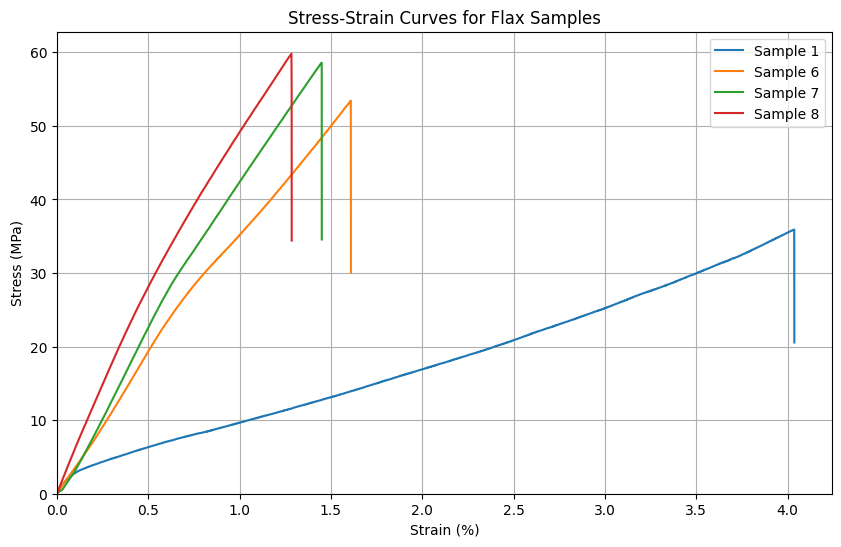

In [3]:
# Define the folder path containing the CSV files
folder_path = 'DestructiveTests/Tensile/FLAX TENSILE.is_qtest_Exports'

# Define a dictionary to map CSV file names to their corresponding gauge lengths and dimensions
# Provide units in mm for dimensions and gauge lengths
# Example: {'SAMPLE_1': (gauge_length, (width, thickness))}
gauge_flax_lengths: t.Dict[int, t.Tuple[float, t.Tuple[float, float]]] = {
    1: (108.45, (24.43, 2.76)),
    2: (None, (None, None)),
    3: (None, (None, None)),
    4: (None, (None, None)),
    5: (None, (None, None)),
    6: (104.18, (25.10, 2.81)),
    7: (104.74, (25.0, 2.76)),
    8: (104.16, (24.06, 2.86)),
}

all_samples_flax: t.List[TensileData] = []

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print("CSV files in the folder:")
# Get each file and its index in the zip
for i, file in enumerate(sorted(csv_files), start=1):
    file_path = os.path.join(folder_path, file)
    try:
        tensile_data = TensileData(
            file_path=file_path,
            internal_name=file.split('.')[0].split('_')[1],
            dimensions=gauge_flax_lengths[i][1],
            gauge_length=gauge_flax_lengths[i][0]
        )
        all_samples_flax.append(tensile_data)
        print(f"Loaded {file} with gauge length {gauge_flax_lengths[i][0]} mm and dimensions {gauge_flax_lengths[i][1]}")
    except Exception as e:
        print(f"Failed to load {file}")

# Plot computed stress vs strain
fig, ax = plt.subplots(figsize=(10, 6))

for sample in all_samples_flax:
    sample.plot_stress_strain(ax_supplied=ax)

ax.set_title("Stress-Strain Curves for Flax Samples")
ax.set_xlabel("Strain (%)")
ax.set_ylabel("Stress (MPa)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)
plt.show()



### Scalograms
Scalograms provide a frequency view of the stress curve. The low frequency (DC) component of the signal has been removed (i.e. the linear trend of the data was subtracted) so that the scalogram was not dominated by low frequency components. The brighter colours indicate stronger frequencies and the darker colours indicate weaker frequencies. Strong spikes such as in FG sample 1 are indiciations of fibres breaking. Interestingly this doesn't happen for flax so it potentially indicates flax just sort of stretches to failiure rather than suddenly breaking. The bright edges of the scalogram can be caused by edge artifacts and may not represent fibre breakage (although the one on the far right of each scalogram almost certainly does as they all suffer a significant drop in stress when they fail). I think these are quite interesting!

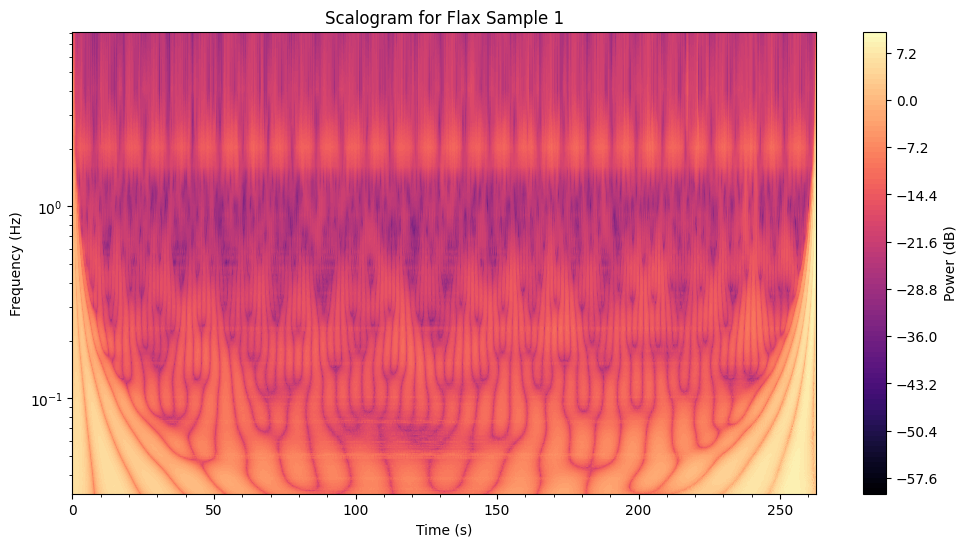

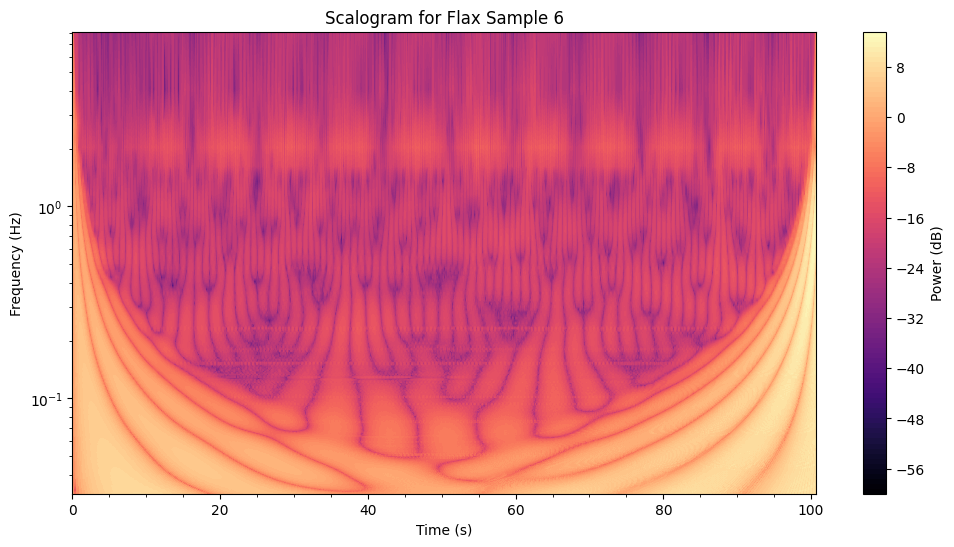

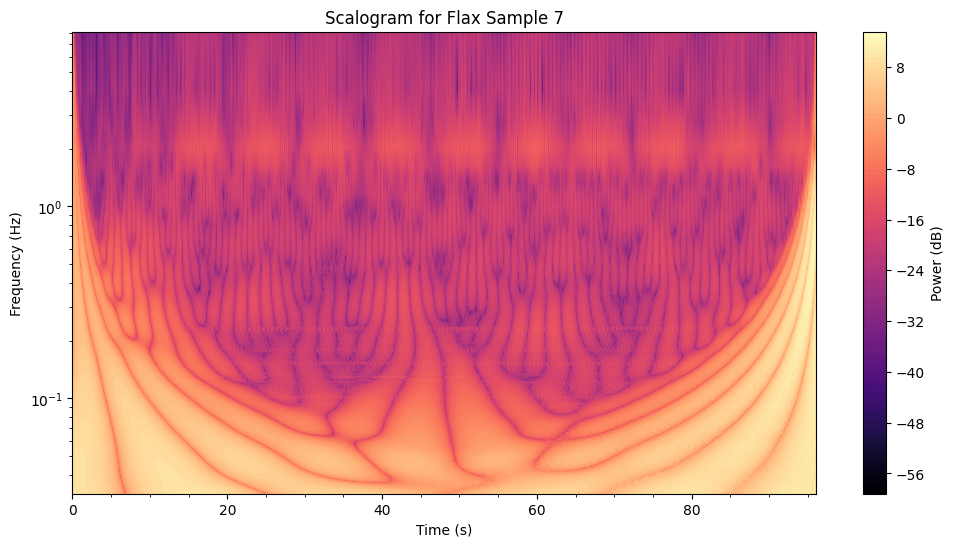

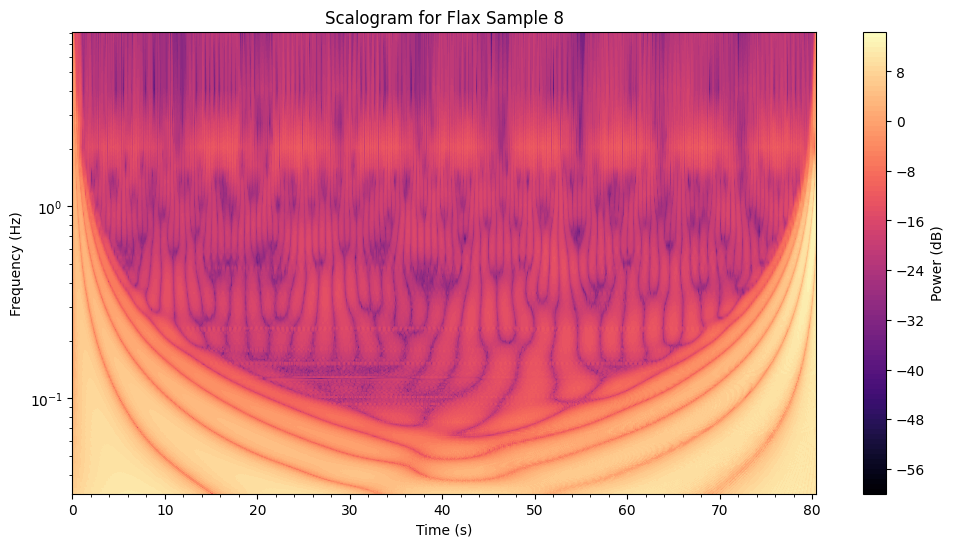

In [4]:
# For each flax sample, compute and plot the scalogram
for sample in all_samples_flax:
    sample.plot_scalogram(title=f"Scalogram for Flax Sample {sample.internal_name}")

## Fibreglass samples

CSV files in the folder:
Loaded FIBERGLASS TENSILE_1.csv with gauge length 89.48 mm and dimensions (23.09, 1.65)
Loaded FIBERGLASS TENSILE_2.csv with gauge length 92.28 mm and dimensions (25.16, 1.65)
Loaded FIBERGLASS TENSILE_3.csv with gauge length 92.22 mm and dimensions (25.64, 1.62)
Loaded FIBERGLASS TENSILE_4.csv with gauge length 92.77 mm and dimensions (23.1, 1.6)


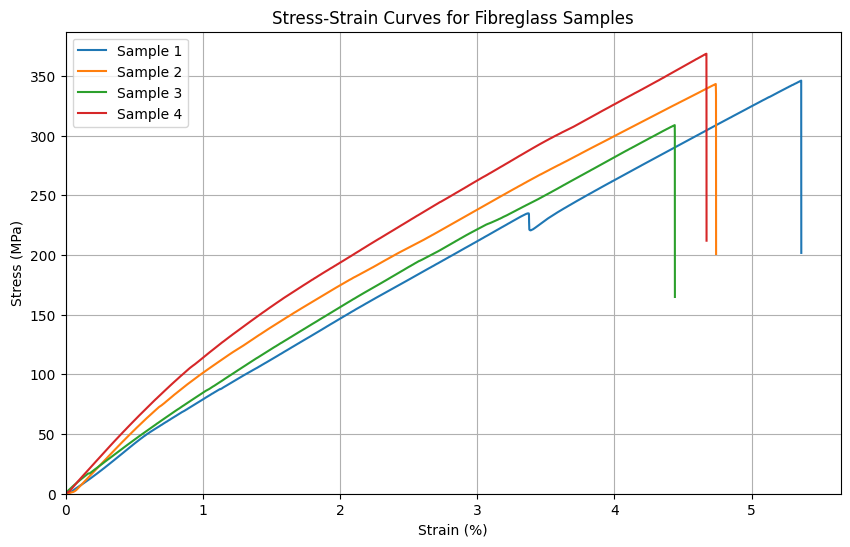

In [5]:
# Define the folder path containing the CSV files
folder_path = 'DestructiveTests/Tensile/FIBERGLASS TENSILE.is_qtest_Exports'

# Define a dictionary to map CSV file names to their corresponding gauge lengths and dimensions
# Provide units in mm for dimensions and gauge lengths
# Example: {'SAMPLE_1': (gauge_length, (width, thickness))}
gauge_fibreglass_lengths: t.Dict[int, t.Tuple[float, t.Tuple[float, float]]] = {
    1: (89.48, (23.09, 1.65)),
    2: (92.28, (25.16, 1.65)),
    3: (92.22, (25.64, 1.62)),
    4: (92.77, (23.10, 1.60)),
}

all_samples_fibreglass: t.List[TensileData] = []

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print("CSV files in the folder:")
# Get each file and its index in the zip
for i, file in enumerate(sorted(csv_files), start=1):
    file_path = os.path.join(folder_path, file)
    try:
        tensile_data = TensileData(
            file_path=file_path,
            internal_name=file.split('.')[0].split('_')[1],
            dimensions=gauge_fibreglass_lengths[i][1],
            gauge_length=gauge_fibreglass_lengths[i][0]
        )
        all_samples_fibreglass.append(tensile_data)
        print(f"Loaded {file} with gauge length {gauge_fibreglass_lengths[i][0]} mm and dimensions {gauge_fibreglass_lengths[i][1]}")
    except Exception as e:
        print(f"Failed to load {file}")

# Plot computed stress vs strain
fig, ax = plt.subplots(figsize=(10, 6))

for sample in all_samples_fibreglass:
    sample.plot_stress_strain(ax_supplied=ax)

ax.set_title("Stress-Strain Curves for Fibreglass Samples")
ax.set_xlabel("Strain (%)")
ax.set_ylabel("Stress (MPa)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)
plt.show()



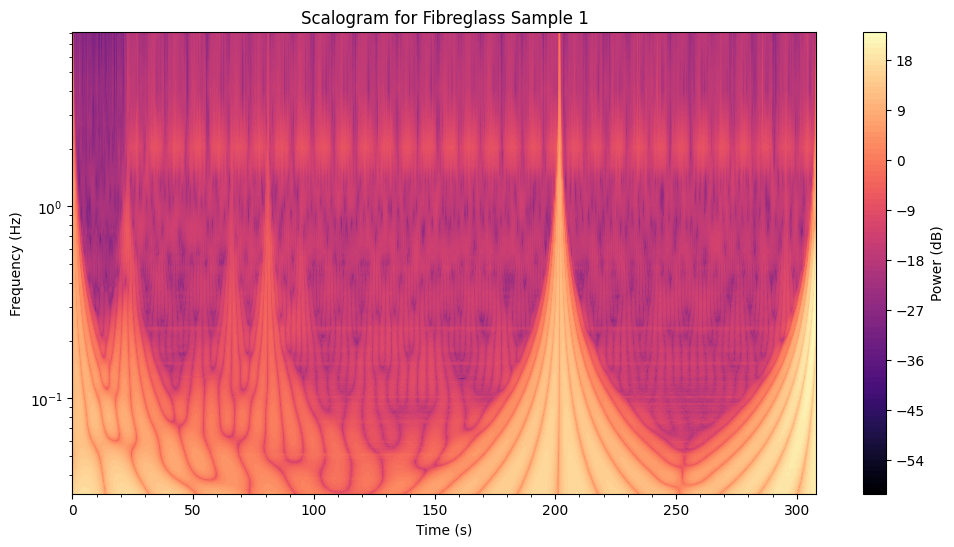

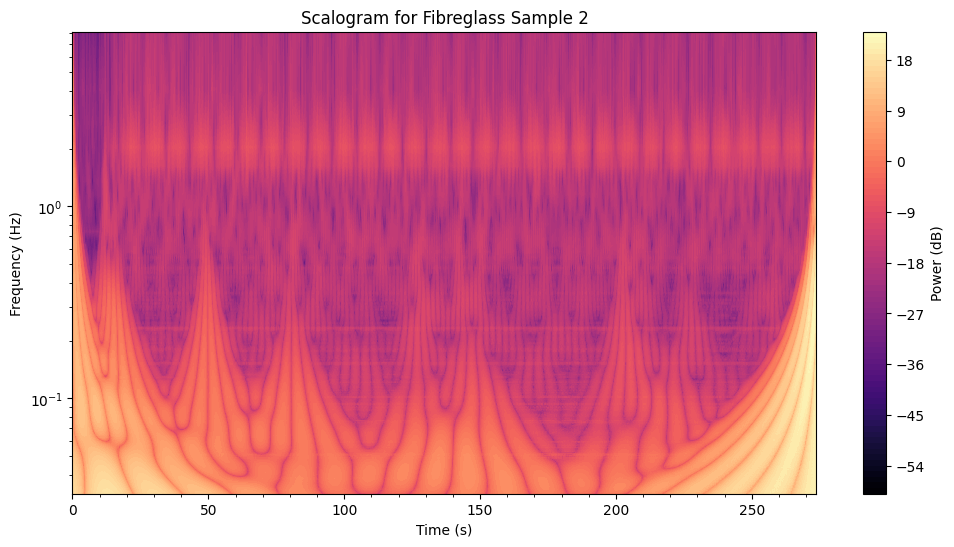

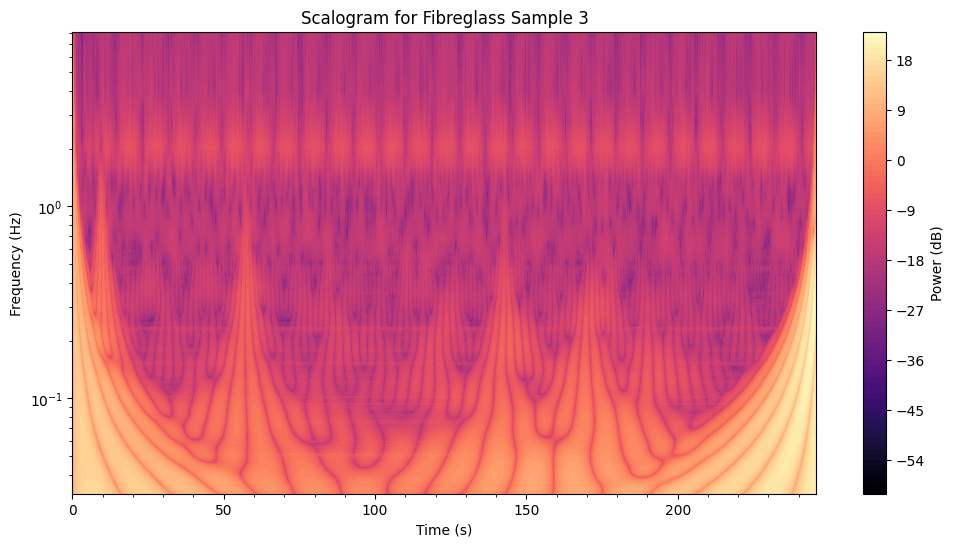

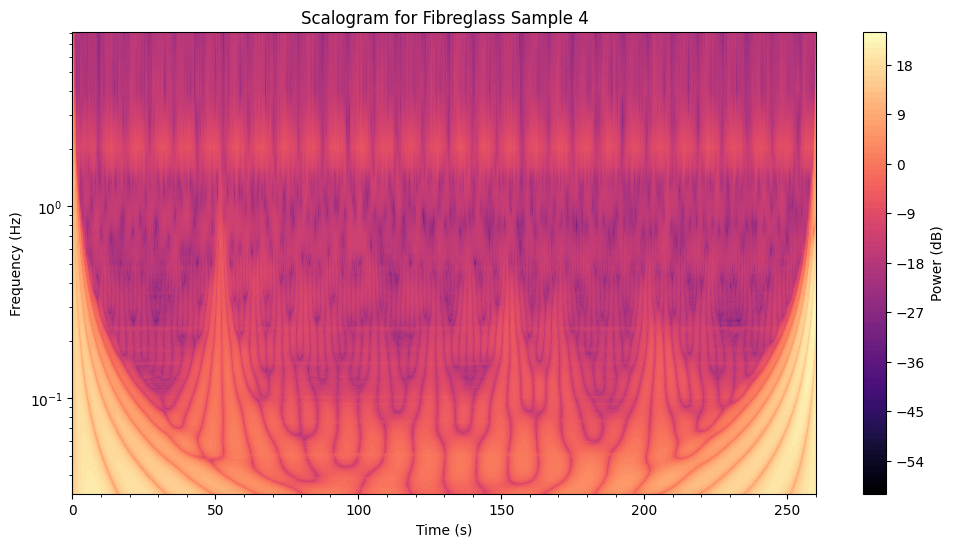

In [6]:
# For each fibreglass sample, compute and plot the scalogram
for sample in all_samples_fibreglass:
    sample.plot_scalogram(title=f"Scalogram for Fibreglass Sample {sample.internal_name}")

## Example usage of scalogram
Below is a scalogram from the 4th Fibre Glass sample. The spike in the scalogram through all frequencies at ~52 seconds shows the sudden drop in the de-linearised stress curve. This could indicate fibre breakage. The POI has been circled red   

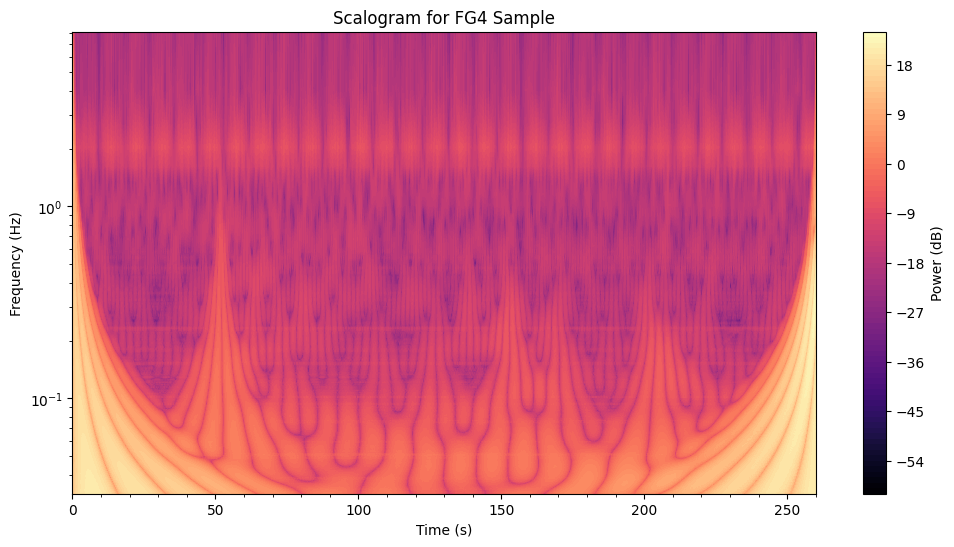

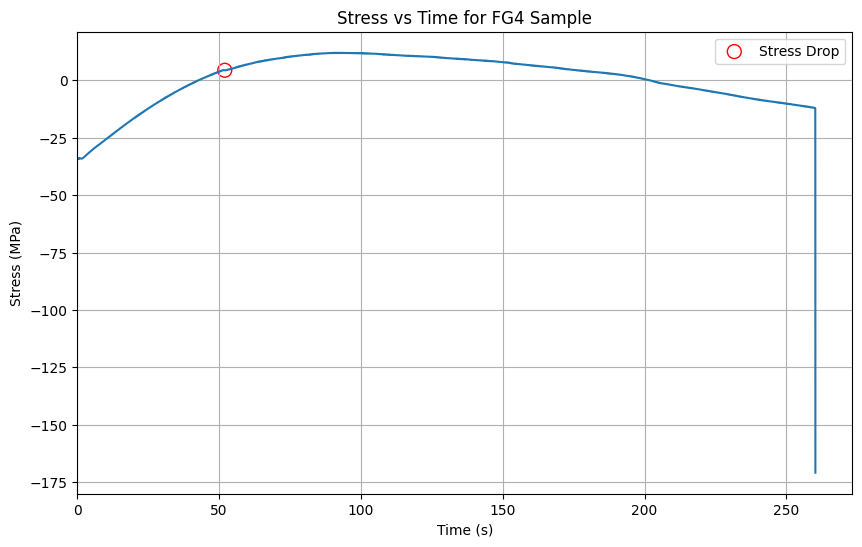

In [7]:
# For FG4 sample, plot the stress vs time at a specific time range
fg4_sample = all_samples_fibreglass[3] 
fg4_sample.plot_scalogram(title="Scalogram for FG4 Sample", useDB=True)

fig, ax = plt.subplots(figsize=(10, 6))
time = fg4_sample.stressStrain_data['Time']
stress = signal.detrend(fg4_sample.stressStrain_data['Stress (MPa)'])
ax.plot(time, stress)
ax.set_title('Stress vs Time for FG4 Sample')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Stress (MPa)')
ax.set_xlim(left=0)
# Highlight a specific stress frequency spike with a hollow circle
ax.scatter(time[520], stress[520], color='red', edgecolor='red', s=100, facecolors='none', label='Stress Drop')
ax.legend()
#ax.set_ylim(min(stress[480:550]), max(stress[480:550]))
ax.grid()
plt.show()

# Bending Test Data Analysis

In [65]:
class FlexuralData(BaseModel):
    file_path: str
    geometry: t.Optional[t.Tuple[float, float, float]] = None  # (width b, height d, span L) in mm
    internal_name: str

    raw_data: t.Optional[pd.DataFrame] = None
    stressStrain_data: t.Optional[pd.DataFrame] = None
    stress_spike_index: t.Optional[int] = None
    _scalogram: t.Optional[t.Dict[str, t.Optional[np.ndarray]]] = PrivateAttr(None)

    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)

    def model_post_init(self, __context):
        # Sanity checks
        b, d, L = self.geometry
        assert L > 5*d, "Span should be much larger than thickness."
        assert 0 < d < b < L, "Check geometry order: (width b, thickness d, span L)."

        # Checks passed. Load the data
        self.load_data()

    def load_data(self):
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File {self.file_path} not found.")

        self.raw_data = pd.read_csv(self.file_path, header=0, skiprows=[1])
        if 'Displacement' in self.raw_data.columns:
            self.raw_data['Displacement'] -= self.raw_data['Displacement'].iloc[0]
        if 'Force' in self.raw_data.columns:
            self.raw_data['Force'] -= self.raw_data['Force'].iloc[0]

        if self.geometry:
            b, d, L = self.geometry  # width, height, span
        else:
            raise ValueError("Geometry (width, height, span) must be provided.")

        if self.raw_data is not None:
            df = self.raw_data.copy()
            # Force (kN) to N
            F = df['Force'] * 1000  # kN to N
            D = df['Displacement']  # in mm

            # Flexural stress and strain
            df['Stress (MPa)'] = (3 * F * L) / (2 * b * d**2)  # N/mm^2 == MPa
            df['Strain'] = (6 * D * d) / (L**2)                # Unitless
            self.stressStrain_data = df
            self.stress_spike_index = self.detect_stress_spike()
            if self.stress_spike_index is not None:
                spike_strain = df['Strain'].iloc[self.stress_spike_index]
                df['Strain'] -= spike_strain
        else:
            raise ValueError("Raw data not loaded.")

    def plot_data(self):
        if self.raw_data is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(self.raw_data['Displacement'], self.raw_data['Force'], linestyle='-', color='b')
            plt.title('Force vs Displacement')
            plt.xlabel('Displacement (mm)')
            plt.ylabel('Force (kN)')
            plt.grid()
            plt.show()
        else:
            raise ValueError("Raw data not loaded.")

    def plot_stress_strain(self, ax_supplied: t.Optional[plt.Axes] = None, label: t.Optional[str] = None, use_percent: bool = True):
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")

        df = self.stressStrain_data
        strain = df['Strain'] * 100 if use_percent else df['Strain']
        stress = df['Stress (MPa)']

        if ax_supplied is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        else:
            ax = ax_supplied

        ax.plot(strain, stress, label=label or f"Sample {self.internal_name}")
        
        if ax_supplied is None:
            ax.set_title('Flexural Stress vs Strain')
            ax.set_xlabel('Strain (%)' if use_percent else 'Strain (unitless)')
            ax.set_ylabel('Stress (MPa)')
            ax.grid(True)
            plt.show()

    def detect_stress_spike(self, window: int = 50, threshold: float = 2.5) -> t.Optional[int]:
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")

        stress_series = self.stressStrain_data['Stress (MPa)']
        differences = stress_series.diff().dropna()
        rolling_mean = differences.rolling(window=window).mean()
        rolling_std = differences.rolling(window=window).std()
        z_scores = (differences - rolling_mean) / rolling_std
        spike_indices = z_scores[z_scores > threshold].index
        if not spike_indices.empty:
            if stress_series.iloc[spike_indices[0]] < 1:
                return spike_indices[0]
        return None

    def compute_scalogram(self):
        if self.stressStrain_data is None:
            raise ValueError("Stress-strain data not available.")
        df = self.stressStrain_data
        stress = df['Stress (MPa)'].values
        stress_dt = signal.detrend(stress)
        dt = 0.1
        scales = np.arange(1, 256)
        coeffs, freqs = pywt.cwt(stress_dt, scales, 'morl', sampling_period=dt)
        power = np.abs(coeffs)
        power_db = 10 * np.log10(power + 1e-6)

        self._scalogram = {
            'time': df['Time'].values,
            'frequencies': freqs,
            'power': power,
            'power_db': power_db
        }

    def plot_scalogram(self, title: t.Optional[str] = None, xlim: t.Optional[t.Tuple[float, float]] = None, useDB: bool = True):
        if not self._scalogram:
            self.compute_scalogram()

        if 'power_db' not in self._scalogram:
            raise ValueError("Scalogram not available.")

        power = self._scalogram['power']
        power_db = self._scalogram['power_db']
        freqs = self._scalogram['frequencies']
        time = self._scalogram['time']

        fig, ax = plt.subplots(figsize=(12,6))
        contour = ax.contourf(time, freqs, power_db if useDB else power, levels=100, cmap='magma')
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        if xlim:
            ax.set_xlim(*xlim)
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title(title or f'Scalogram of Stress Signal - {self.internal_name}')
        fig.colorbar(contour, ax=ax, label='Power (dB)')
        plt.show()


CSV files in the folder:
Loaded FLAX_1.csv with dimensions: Span 32.0, Width 12.42, Thickness 1.45
Loaded FLAX_2.csv with dimensions: Span 32.0, Width 13.01, Thickness 1.4
Loaded FLAX_3.csv with dimensions: Span 32.0, Width 13.28, Thickness 1.46
Loaded FLAX_4.csv with dimensions: Span 32.0, Width 12.87, Thickness 1.53
Loaded FLAX_5.csv with dimensions: Span 32.0, Width 13.23, Thickness 1.59
Loaded FLAX_6.csv with dimensions: Span 32.0, Width 12.77, Thickness 1.54


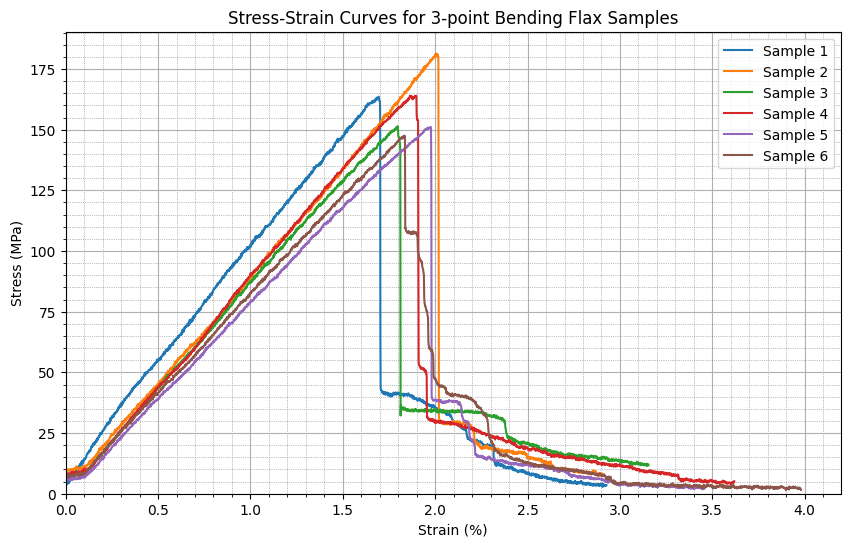

In [ ]:
# Define the folder path containing the CSV files
folder_path = 'DestructiveTests/BendingTest/FLAX.is_qtest_Exports'

# Define a dictionary to map CSV file names to their corresponding gauge lengths and dimensions
# Provide units in mm for dimensions and gauge lengths
# Example: {'SAMPLE_1': (gauge_length, (width, thickness))}
bending_dims_flax: t.Dict[int, t.Tuple[float, float, float]] = {
    1: (32.0, 12.42, 1.45),
    2: (32.0, 13.01, 1.4),
    3: (32.0, 13.28, 1.46),
    4: (32.0, 12.87, 1.53),
    5: (32.0, 13.23, 1.59),
    6: (32.0, 12.77, 1.54),
}

all_bend_samples_flax: t.List[FlexuralData] = []

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print("CSV files in the folder:")
# Get each file and its index in the zip
for i, file in enumerate(sorted(csv_files), start=1):
    file_path = os.path.join(folder_path, file)
    try:
        span, width, thickness = bending_dims_flax[i]
        flexural_data = FlexuralData(
            file_path=file_path,
            internal_name=file.split('.')[0].split('_')[1],
            geometry=(width, thickness, span),
        )
        all_bend_samples_flax.append(flexural_data)
        print(f"Loaded {file} with dimensions: Span {span}, Width {width}, Thickness {thickness}")
    except Exception as e:
        print(f"Failed to load {file}")


if len(all_bend_samples_flax) == 0:
    print("No bending samples loaded. Please check the folder path, CSV files, and bending dimensions.")
else:
    # Plot computed stress vs strain
    fig, ax = plt.subplots(figsize=(10, 6))

    for sample in all_bend_samples_flax:
        #sample.stressStrain_data['Strain'] -= 0.0032
        sample.plot_stress_strain(ax_supplied=ax)

    ax.set_title("Stress-Strain Curves for 3-point Bending Flax Samples")
    ax.set_xlabel("Strain (%)")
    ax.set_ylabel("Stress (MPa)")
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax.minorticks_on()
    ax.legend()
    ax.grid(True)
    plt.show()




CSV files in the Fibre Glass folder:
Loaded FIBERGLASS_1.csv with dimensions: Span 32.0, Width 13.28, Thickness 1.54
Loaded FIBERGLASS_2.csv with dimensions: Span 32.0, Width 11.84, Thickness 1.72
Loaded FIBERGLASS_3.csv with dimensions: Span 32.0, Width 11.77, Thickness 1.66
Loaded FIBERGLASS_4.csv with dimensions: Span 32.0, Width 13.45, Thickness 1.64
Loaded FIBERGLASS_5.csv with dimensions: Span 32.0, Width 12.4, Thickness 1.5


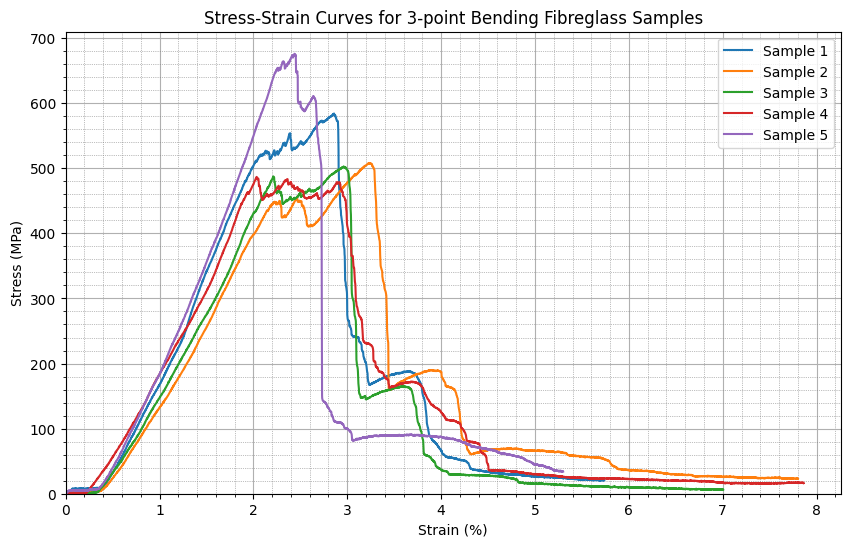

In [71]:
# Define the folder path containing the CSV files for Fibre Glass bending samples
folder_path_fg = 'DestructiveTests/BendingTest/FIBERGLASS.is_qtest_Exports'

# Define a dictionary to map CSV file names to their corresponding dimensions (span, width, thickness)
bending_dims_fg: t.Dict[int, t.Tuple[float, float, float]] = {
    1: (32.0, 13.28, 1.54),
    2: (32.0, 11.84, 1.72),
    3: (32.0, 11.77, 1.66),
    4: (32.0, 13.45, 1.64),
    5: (32.0, 12.4, 1.5),
}

all_bend_samples_fg: t.List[FlexuralData] = []

# List all CSV files in the folder
csv_files_fg = [f for f in os.listdir(folder_path_fg) if f.endswith('.csv')]
print("CSV files in the Fibre Glass folder:")
# Get each file and its index in the zip
for i, file in enumerate(sorted(csv_files_fg), start=1):
    file_path = os.path.join(folder_path_fg, file)
    try:
        span, width, thickness = bending_dims_fg[i]
        flexural_data = FlexuralData(
            file_path=file_path,
            internal_name=file.split('.')[0].split('_')[1],
            geometry=(width, thickness, span),
        )
        all_bend_samples_fg.append(flexural_data)
        print(f"Loaded {file} with dimensions: Span {span}, Width {width}, Thickness {thickness}")
    except Exception as e:
        print(f"Failed to load {file}")

if len(all_bend_samples_fg) == 0:
    print("No Fibre Glass bending samples loaded. Please check the folder path, CSV files, and bending dimensions.")
else:
    # Plot computed stress vs strain
    fig, ax = plt.subplots(figsize=(10, 6))

    for sample in all_bend_samples_fg:
        sample.plot_stress_strain(ax_supplied=ax)

    ax.set_title("Stress-Strain Curves for 3-point Bending Fibreglass Samples")
    ax.set_xlabel("Strain (%)")
    ax.set_ylabel("Stress (MPa)")
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid(True)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax.minorticks_on()
    plt.show()


In [22]:
import json
from statistics import mean
import numpy as np


def _compute_modulus_from_df(
    df,
    stress_col: str = "Stress (MPa)",
    strain_col: str = "Strain",
    outlier_z_thresh: float = 3.5,
    min_points_linear: int = 5,
):
    """
    Estimate modulus as the slope of the initial linear region of the stress–strain curve.
    Performs a robust refit after removing likely outliers based on residual MAD.

    Returns:
        slope_mpa_per_strain (float), n_outliers_removed (int)
    """
    # Basic validation
    if df is None or stress_col not in df.columns or strain_col not in df.columns:
        raise ValueError(f"Missing required columns {stress_col} and/or {strain_col}")

    stress = df[stress_col].astype(float)
    strain = df[strain_col].astype(float)

    # Remove NaNs
    mask = (~stress.isna()) & (~strain.isna())
    stress = stress[mask]
    strain = strain[mask]

    if len(stress) < 10:
        raise ValueError("Insufficient data points (<10) to compute modulus")

    # Approximate linear region: up to 30% of max stress
    max_stress = stress.max()
    if max_stress <= 0:
        raise ValueError("Non positive maximum stress; cannot compute modulus")

    linear_mask = stress <= 0.30 * max_stress
    lin_stress = stress[linear_mask]
    lin_strain = strain[linear_mask]

    # Fallback if too few points in region
    if len(lin_stress) < 15:
        n = min(50, len(stress))
        lin_stress = stress.iloc[:n]
        lin_strain = strain.iloc[:n]

    if len(lin_stress) < min_points_linear:
        raise ValueError("Too few points in presumed linear region to fit (need >=5)")

    # Initial linear regression
    try:
        slope, intercept = np.polyfit(lin_strain.values, lin_stress.values, 1)
    except Exception as e:
        raise ValueError(f"Linear fit failed: {e}")

    if slope <= 0:
        raise ValueError("Computed non positive slope for modulus")

    # Compute residuals and do robust outlier removal (MAD based)
    pred = slope * lin_strain.values + intercept
    resid = lin_stress.values - pred
    abs_resid = np.abs(resid)
    med_abs_resid = np.median(abs_resid)

    n_outliers = 0
    keep_idx = np.arange(len(lin_strain))

    if med_abs_resid > 0:
        # Robust z score using MAD
        robust_z = 0.6745 * abs_resid / med_abs_resid
        keep_mask = robust_z <= outlier_z_thresh
        n_outliers = int((~keep_mask).sum())
        if n_outliers and keep_mask.sum() >= min_points_linear:
            lin_strain = lin_strain.iloc[keep_mask.nonzero()[0]]
            lin_stress = lin_stress.iloc[keep_mask.nonzero()[0]]
        elif n_outliers and keep_mask.sum() < min_points_linear:
            # If removing outliers leaves too few points, keep original set
            n_outliers = 0
    else:
        # Fallback to IQR if MAD is zero
        q1, q3 = np.percentile(abs_resid, [25, 75])
        iqr = q3 - q1
        if iqr > 0:
            cutoff = q3 + 1.5 * iqr
            keep_mask = abs_resid <= cutoff
            n = int((~keep_mask).sum())
            if n and keep_mask.sum() >= min_points_linear:
                lin_strain = lin_strain.iloc[keep_mask.nonzero()[0]]
                lin_stress = lin_stress.iloc[keep_mask.nonzero()[0]]
                n_outliers = n

    # Refit after outlier removal if any
    try:
        slope, intercept = np.polyfit(lin_strain.values, lin_stress.values, 1)
    except Exception as e:
        raise ValueError(f"Linear refit failed: {e}")

    if slope <= 0:
        raise ValueError("Computed non positive slope for modulus after outlier removal")

    return float(slope), int(n_outliers)


def process_samples(samples):
    """
    Process a list of sample objects and compute moduli.
    Warns when outlier points are excluded for any sample.
    """
    results = []
    warnings = []
    tensile_moduli = []
    flexural_moduli = []

    for idx, sample in enumerate(samples, start=1):
        sample_id = getattr(sample, "internal_name", f"sample_{idx}")
        sample_type = type(sample).__name__

        try:
            if sample_type == "TensileData":
                df = getattr(sample, "stressStrain_data", None)
                if df is None:
                    raise ValueError("stressStrain_data is None")
                modulus, n_out = _compute_modulus_from_df(df)
                results.append({"id": sample_id, "type": sample_type, "youngs_modulus_mpa": modulus})
                tensile_moduli.append(modulus)
                if n_out > 0:
                    warnings.append(
                        f"Sample {idx} ({sample_id}) tensile fit excluded {n_out} likely outlier point(s)."
                    )

            elif sample_type == "FlexuralData":
                df = getattr(sample, "stressStrain_data", None)
                if df is None:
                    raise ValueError("stressStrain_data is None")
                modulus, n_out = _compute_modulus_from_df(df)
                results.append({"id": sample_id, "type": sample_type, "flexural_modulus_mpa": modulus})
                flexural_moduli.append(modulus)
                if n_out > 0:
                    warnings.append(
                        f"Sample {idx} ({sample_id}) flexural fit excluded {n_out} likely outlier point(s)."
                    )

            else:
                warnings.append(f"Sample {idx} ({sample_id}) has unsupported type {sample_type}, skipped.")

        except Exception as e:
            warnings.append(f"Sample {idx} ({sample_id}, {sample_type}) skipped: {e}")

    averages = {}
    if tensile_moduli:
        averages["youngs_modulus_mpa"] = mean(tensile_moduli)
    if flexural_moduli:
        averages["flexural_modulus_mpa"] = mean(flexural_moduli)

    output = {
        "results": results,
        "averages": averages,
        "warnings": warnings,
    }

    # Validation: ensure keys
    for r in results:
        if r.get("type") == "TensileData" and "youngs_modulus_mpa" not in r:
            warnings.append(f"Result for {r.get('id')} missing youngs_modulus_mpa key")
        if r.get("type") == "FlexuralData" and "flexural_modulus_mpa" not in r:
            warnings.append(f"Result for {r.get('id')} missing flexural_modulus_mpa key")

    print(json.dumps(output, indent=2))
    return output


In [23]:
flax_results_E = process_samples(all_samples_flax)
fg_results_E = process_samples(all_samples_fibreglass)

flax_results_eM = process_samples(all_bend_samples_flax)
fg_results_eM = process_samples(all_bend_samples_fg)


{
  "results": [
    {
      "id": "1",
      "type": "TensileData",
      "youngs_modulus_mpa": 746.9066012124392
    },
    {
      "id": "6",
      "type": "TensileData",
      "youngs_modulus_mpa": 3780.1306650485394
    },
    {
      "id": "7",
      "type": "TensileData",
      "youngs_modulus_mpa": 4026.5969460989754
    },
    {
      "id": "8",
      "type": "TensileData",
      "youngs_modulus_mpa": 5866.500629539135
    }
  ],
  "averages": {
    "youngs_modulus_mpa": 3605.0337104747723
  },
  "warnings": [
    "Sample 1 (1) tensile fit excluded 18 likely outlier point(s)."
  ]
}
{
  "results": [
    {
      "id": "1",
      "type": "TensileData",
      "youngs_modulus_mpa": 7263.835686295529
    },
    {
      "id": "2",
      "type": "TensileData",
      "youngs_modulus_mpa": 10143.425884797489
    },
    {
      "id": "3",
      "type": "TensileData",
      "youngs_modulus_mpa": 8220.176385907058
    },
    {
      "id": "4",
      "type": "TensileData",
      "youngs_mo

In [11]:
import numpy as np

def compute_modulus_from_range(df, start_strain, end_strain,
                               stress_col="Stress (MPa)", strain_col="Strain"):
    """
    Compute modulus from a specified strain window.
    
    Args:
        df : pandas DataFrame with stress–strain data
        start_strain : float, minimum strain for region
        end_strain   : float, maximum strain for region
        stress_col   : column name for stress values
        strain_col   : column name for strain values
        
    Returns:
        slope (float) = modulus in MPa
    """
    if df is None or stress_col not in df.columns or strain_col not in df.columns:
        raise ValueError(f"Missing required columns {stress_col} and/or {strain_col}")

    stress = df[stress_col].astype(float)
    strain = df[strain_col].astype(float)

    # Filter to user-specified range
    mask = (strain >= start_strain) & (strain <= end_strain)
    sub_strain = strain[mask]
    sub_stress = stress[mask]
    print(f"{stress[mask[0]]} to {stress[mask[-1]]}")

    if len(sub_strain) < 2:
        raise ValueError("Not enough points in the specified strain range")

    slope, intercept = np.polyfit(sub_strain.values, sub_stress.values, 1)
    return float(slope)


# Compute the moduli and the averages
These values seem very small...

In [ ]:
num_dp = 3

# Young's modulus (tensile, GPa)
fg_youngs = [{samples.internal_name: np.round(compute_modulus_from_range(samples.stressStrain_data, 0.005, 0.01)/1000, num_dp)} for samples in all_samples_fibreglass]
flax_youngs = [{samples.internal_name: np.round(compute_modulus_from_range(samples.stressStrain_data, 0.005, 0.01)/1000, num_dp)} for samples in all_samples_flax]

# Elastic modulus (flexural, GPa)
fg_flexural = [{samples.internal_name: np.round(compute_modulus_from_range(samples.stressStrain_data, 0.0075, 0.0125)/1000, num_dp)} for samples in all_bend_samples_fg]
flax_flexural = [{samples.internal_name: np.round(compute_modulus_from_range(samples.stressStrain_data, 0.0075, 0.0125)/1000, num_dp)} for samples in all_bend_samples_flax]

print("Young's Modulus GPa")
print(f"FG:   {fg_youngs}")
print(f"FLAX: {flax_youngs}")
print("Elastic Modulus GPa")
print(f"FG:   {fg_flexural}")
print(f"FLAX: {flax_flexural}")

# Compute means (ignore failed/NaN values)
def extract_values(dict_list):
    vals = []
    for d in dict_list:
        for v in d.values():
            if not np.isnan(v):
                vals.append(v)
    return vals

fg_youngs_mean = np.round(np.mean(extract_values(fg_youngs)), num_dp)
flax_youngs_mean = np.round(np.mean(extract_values(flax_youngs)), num_dp)
fg_flexural_mean = np.round(np.mean(extract_values(fg_flexural)), num_dp)
flax_flexural_mean = np.round(np.mean(extract_values(flax_flexural)), num_dp)

print("\nMean Young's Modulus (GPa):")
print(f"FG:   {fg_youngs_mean}")
print(f"FLAX: {flax_youngs_mean}")
print("Mean Elastic Modulus (GPa):")
print(f"FG:   {fg_flexural_mean}")
print(f"FLAX: {flax_flexural_mean}")

Young's Modulus GPa
FG:   [{'1': 7.273}, {'2': 9.532}, {'3': 7.887}, {'4': 10.567}]
FLAX: [{'1': 0.649}, {'6': 3.106}, {'7': 3.853}, {'8': 4.186}]
Elastic Modulus GPa
FG:   [{'1': 27.558}, {'2': 22.305}, {'3': 25.058}, {'4': 26.506}, {'5': 30.931}]
FLAX: [{'1': 9.658}, {'2': 8.476}, {'3': 8.58}, {'4': 9.114}, {'5': 7.833}, {'6': 8.106}]

Mean Young's Modulus (GPa):
FG:   8.815
FLAX: 2.948
Mean Elastic Modulus (GPa):
FG:   26.472
FLAX: 8.628


In [76]:
np.max(all_samples_fibreglass[3].stressStrain_data['Force'])

13.6251

# Secondary Flax Tensile Tests

CSV files in the folder:
[FLXT2] Loaded Flax 2_1.csv with gauge length 95.81 mm and dimensions (24.76, 2.32)
[FLXT2] Loaded Flax 2_2.csv with gauge length 96.0 mm and dimensions (23.38, 2.49)
[FLXT2] Loaded Flax 2_3.csv with gauge length 96.27 mm and dimensions (25.35, 2.45)


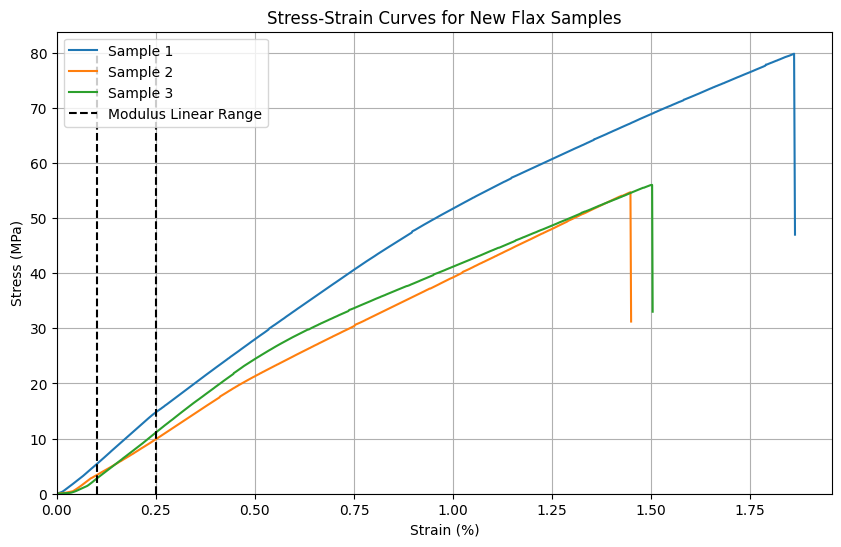

KeyError: False

In [12]:
# Define the folder path containing the CSV files
folder_path = 'DestructiveTests/TensileFlax2'

# Define a dictionary to map CSV file names to their corresponding gauge lengths and dimensions
# Provide units in mm for dimensions and gauge lengths
# Example: {'SAMPLE_1': (gauge_length, (width, thickness))}
gauge_flax_lengths: t.Dict[int, t.Tuple[float, t.Tuple[float, float]]] = {
    1: (95.81, (24.76, 2.32)),
    2: (96.00, (23.38, 2.49)),
    3: (96.27, (25.35, 2.45)),
}

flax_tensile_secondary_tests: t.List[TensileData] = []

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print("CSV files in the folder:")
# Get each file and its index in the zip
for i, file in enumerate(sorted(csv_files), start=1):
    file_path = os.path.join(folder_path, file)
    try:
        tensile_data = TensileData(
            file_path=file_path,
            internal_name=file.split('.')[0].split('_')[1],
            dimensions=gauge_flax_lengths[i][1],
            gauge_length=gauge_flax_lengths[i][0]
        )
        flax_tensile_secondary_tests.append(tensile_data)
        print(f"[FLXT2] Loaded {file} with gauge length {gauge_flax_lengths[i][0]} mm and dimensions {gauge_flax_lengths[i][1]}")
    except Exception as e:
        print(f"[FLXT2] Failed to load {file}")

# Modulus range
modulus_range = (0.1, 0.25) # In %
modulus_range_unitless = (modulus_range[0]/100, modulus_range[1]/100)

# Plot computed stress vs strain
fig, ax = plt.subplots(figsize=(10, 6))

for sample in flax_tensile_secondary_tests:
    sample.plot_stress_strain(ax_supplied=ax)

ax.set_title("Stress-Strain Curves for New Flax Samples")
ax.set_xlabel("Strain (%)")
ax.set_ylabel("Stress (MPa)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True)
ax.vlines(x=modulus_range, ymin=0, ymax=80, color='k', linestyle='--', label="Modulus Linear Range")
ax.legend()
plt.show()

# Compute modulus
num_dp = 3
flax2_youngs = [{samples.internal_name: np.round(compute_modulus_from_range(samples.stressStrain_data, *modulus_range_unitless)/1000, num_dp)} for samples in flax_tensile_secondary_tests]
print("Young's Modulus GPa")
print(f"FLAX: {flax2_youngs}")